# 1. tool (5 баллов)

В этом блоке вам нужно будет написать две функции для анализа методов приближенного поиска ближайших соседей. Без этих функций использование таких методов довольно затруднительно.

Также, эти функции пригодятся вам при выполнении следующего блока.

Их нужно будет написать в `utils.py`, после чего импортировать в этот ноутбук для использования. Также, в `utils.py` вас ждут некоторые готовые функции, которые пригодятся вам в этой домашке.

Блок будет оцениваться по стандартным tool-правилам. Не забывайте про докстринги, комменты к коду, адекватность. Ориентируйтесь на примеры - они правильные :)

Все что вы напишете в рамках этого задания и все, что уже написано за вас - очень пригодится вам в будущем, обязательно сохраняйте это себе!

## 1.1 `plot_ann_performance` (3 балла)

Нужно написать функцию, которая специальным образом принимает на вход несколько "алгоритмов" приближенного поиска соседей, а также индекс для точного поиска соседей, после чего рисует на графике качество и скорость приближенного поиска для каждого из переданных алгоритмов, а также время построения индексов. Под качеством будем подразумевать `recall@k` - долю правильно найденных k ближайших соседей (сравниваем с точным поиском). Функция подсчета качества вам дана; она также возвращает ошибки, которые вам понадобятся для второй функции. 

Итак, функция должна принимать:
- `build_data`, на которой будут строиться индексы подаваемых на вход алгоритмов
- `query_data`, для которой будут искаться соседи
- `index_dict`: словарик {'index_name': словарик с необходимым*, ...} с необходимой инфой для каждого из исследуемых алгоритмов aNN (см. пример)
- `k` для меры качества
- `flat_build_func`: функция, которая строит Flat-индекс (см. пример)
- `flat_search_func`: функция, которая ищет в Flat-индексе (см. пример)
- `query_in_train`: флаг того, что query_data содержится в build_data. Если это так, мерим качество по k соседям без учета
    ближайшего
- `qps_line`: float. Если указано, нарисуем горизонтальную линию по этому значению
- `recall_line`: float. Если указано, нарисуем вертикальную линию по этому значению
- `title`: str. Если указан, сделать у графика такой title 

Функционал:
- каждый алгоритм задается `fixed_params` и несколькими значениями `speed_param`. Индекс строится по fixed_params, поиск производится с параметром поиска speed_param. Для каждой пары (fixed_params, speed_param_i) у кривой, соотв. индексу, появляется точка на графике.
- эти точки надо подписывать (см. пример) напр. с помощью `ax.annotate`
- скорость поиска измеряется в queries / sec
- нужно отрисовать линию скорости FlatIndex
- нужно вывести в отдельный ax время построения каждого из индексов (напр. в виде barplot)


Остальное:
- сложнее понять задание, чем написать функцию :)
- примеры `build_func`, `search_func` находятся в `index.py`. Там же следует писать и остальные требуемые функции подобного рода. Их вам нужно будет дописывать по мере движения вниз по домашке. Что-то понадобилось - написали.
- в этой домашке в качестве Flat индекса всегда будем передавать `faiss.IndexFlat[L2/IP]`
- не забывайте удалять уже ненужные индексы - они занимают память
- это ничего, что speed_params налазят друг на друга на графике
- следите за размером шрифтов и линий

In [1]:
%load_ext autoreload
%autoreload 2

from utils.utils import plot_ann_performance, analyze_ann_method
from utils.index import *
from functools import partial
import numpy as np

n = 10000
dim = 25

np.random.seed(911)
X = np.random.randn(n, dim)

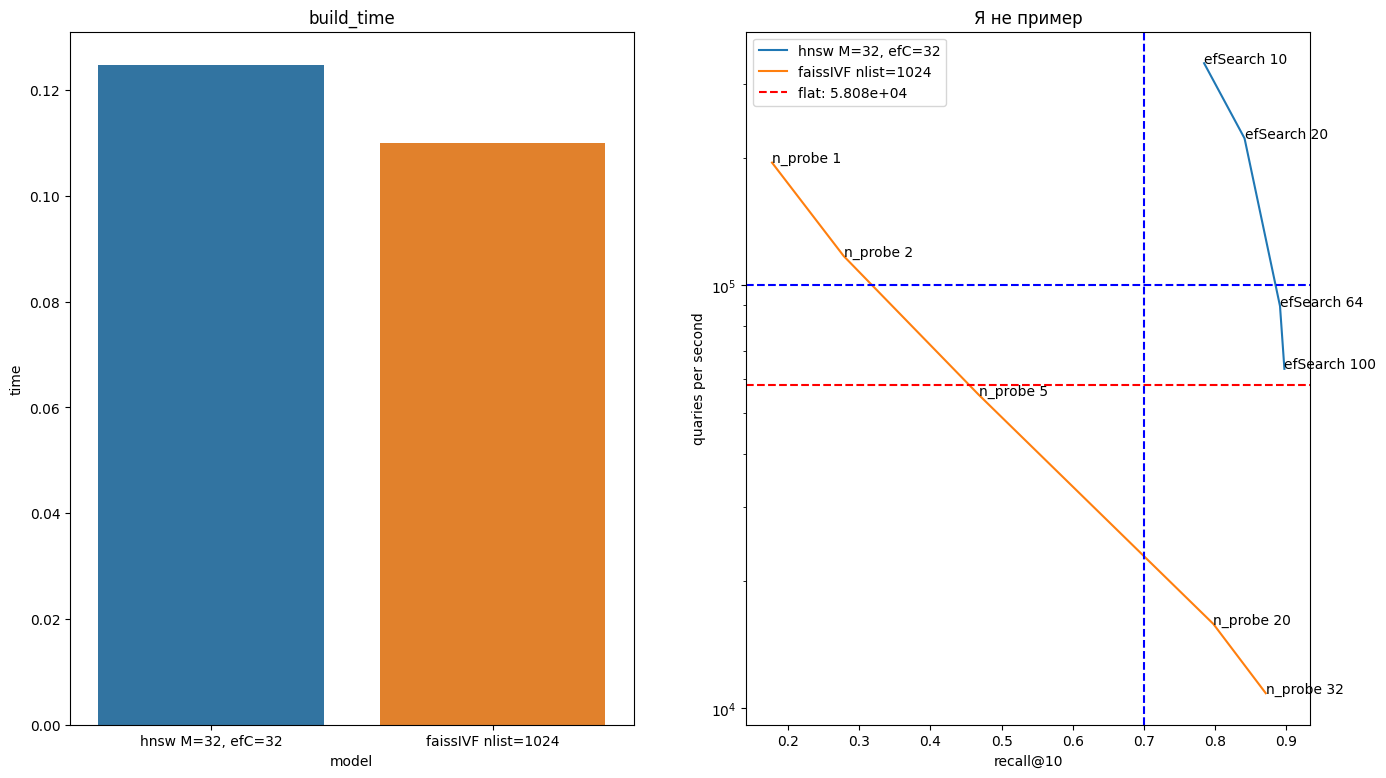

In [13]:
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=X,
    query_data=X[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.7
)

## 1.2 `analyze_ann_method` (2 балла)

Нужно написать функцию, которая специальным образом принимает на вход один алгоритм приближенного поиска соседей, после чего рисует на графике распределение количества ошибок для этого алгоритма. Под алгоритмом понимается фиксированная пара (index, search_param).
Функция `calc_recall` для каждого объекта из query_data подсчитывает, сколько ошибочных соседей было найдено для этого объекта, после чего возвращает эти ошибки, если ее попросить. Используйте это.

Аргументы можете наблюдать в примере.

Функционал:
- распределение ошибок
- подписать бины (напр. `barContainer = ax.bar(...)` -> `ax.bar_label(barContainer, ...)`)
- чистые нули отобразить чем-то отрицательным
- где-нибудь разместить информацию о времени построения индекса, скорости поиска и качестве (см. пример - легенда)

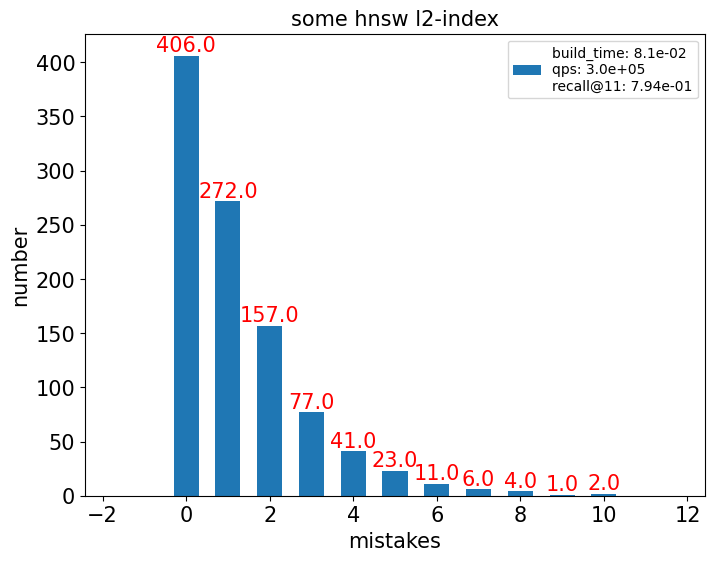

In [4]:
# ПРИМЕР, НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ

analyze_ann_method(
    build_data=X,
    query_data=X[:1000],
    build_func=partial(build_hnsw, fixed_params = {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32}),
    search_func=partial(search_hnsw, efSearch=10),
    k=11,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    index_name='some hnsw l2-index'
)

# 2. Кейсы (4 балла)

В данном блоке вам предстоит "решить" три кейса (мини-задачки с разными датасетами), используя написанные инструменты.
Задания даны под каждым кейсом. Оценивается как правильность решения, так и адекватность рассуждений.


В этом ноутбуке следует приводить только те графики / ячейки / куски кода, которые вам нужны для конечных рассуждений. Любая исследовательская работа, напрямую не относящаяся к вашим словам, должна быть выполенена в другом ноутбуке, который тоже нужно прикрепить. На другой ноутбук можно ссылаться вроде "Я много чего протестировал (см. ноутбук research), там все плохо было, а вот ХОРОШО уже тут...".

Для начала запустите ячейки ниже - там функция, которая подгружает необходимые данные.

In [5]:
!pip install h5py

In [2]:
import numpy as np
import h5py
from urllib.request import urlretrieve
import os

%load_ext autoreload
%autoreload 2

def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1 GloVe

Датасет содержит векторы-представления некоторых слов

In [3]:
tr_glove, tst_glove = get_ann_benchmark_data('glove-25-angular')
tr_glove.shape, tst_glove.shape

((1183514, 25), (10000, 25))

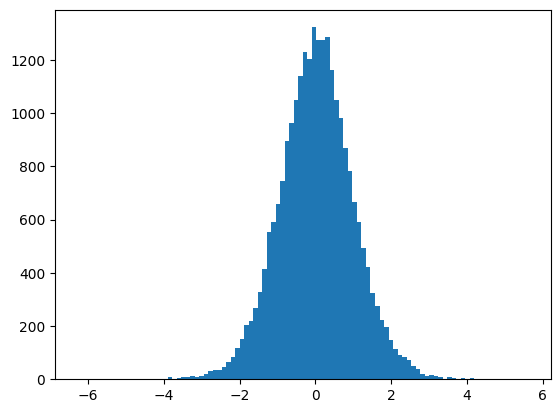

In [21]:
import matplotlib.pyplot as plt

plt.hist(tr_glove[:1000].ravel(), bins=100)
plt.show()

**Задание:**

Представьте, что вам будут поступать онлайн-запросы с векторами такой же природы (полученными из слов тем же образом). Запросы поступают батчами, вам нужно для каждого батча в режиме реального времени возвращать 10 ближайших из трейна соседей по евклидовой метрике. Запросов очень много, они поступают непрерывно.


Вам нужно построить оптимальные индексы на тренировочных данных, решающие задачу и удовлетворяющие требованию:
1. минимальная скорость на возврат соседей равна `10 * flat_l2_qps` queries / sec `(один индекс для этого требования)`
2. получить максимальное качество соседей (все, что лучше recall@10=0.99 считаем за идеальное качество) `(и один индекс для этого требования)`


- считаем, что памяти дано столько, сколько доступно лично вам при выполнении этой домашки
- "сдать" индекс надо "сегодня", поэтому "максимальное" время построения индекса - примерно 5-6 минут

Доступные индексы, которые могут стать ответом: `faiss.IndexFlat[L2/IP]`, `faiss.IndexIVFFlat`, `faiss.IndexIVFPQ`, `hnswlib.Index`


<br><br>
Используйте функцию `plot_ann_performance`, чтобы определить, какой индекс лучше всего подойдет для какой задачи.
Обычно, параметры для построения индекса и поиска по нему имеют понятную интуицию трейдоффа между скоростью построения индекса, скоростью поиска, качеством найденных соседей и памятью, поэтому использовать что-то вроде optuna для подбора этих параметров - overkill, вы быстро нащупаете нужные диапазоны по графикам. Для попытки нащупать оптимальные параметры, можно использовать сэмпл меньшего размера из трейна в качестве build_data и из теста в качестве query_data, однако конечные выводы должны основываться на графиках, полученных на всех данных трейна и на достаточном количестве query-данных, чтобы оценить queries_per_second. 


Опишите эти два индекса и причины, по которым вы сделали выбор:
- приведите необходимые графики
- напишите свои рассуждения и выводы
- проверьте адекватность распределения кол-ва ошибок - согласуется ли оно с интуицией?
- опишите также свои мысли на тему остальных индексов в контексте каждого из требований <br>


Например: "Для второй задачи лучше всего подойдет `faiss.IndexIVFPQ, nlist=1024, m=4, nbits=8`, потому что ..."


Рекомендации и интуицию по параметрам смотрите тут:
- hnsw:
    - https://github.com/nmslib/nmslib/blob/master/manual/methods.md
    - https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    - https://www.pinecone.io/learn/series/faiss/hnsw/

- faiss:
    - https://github.com/facebookresearch/faiss/wiki/

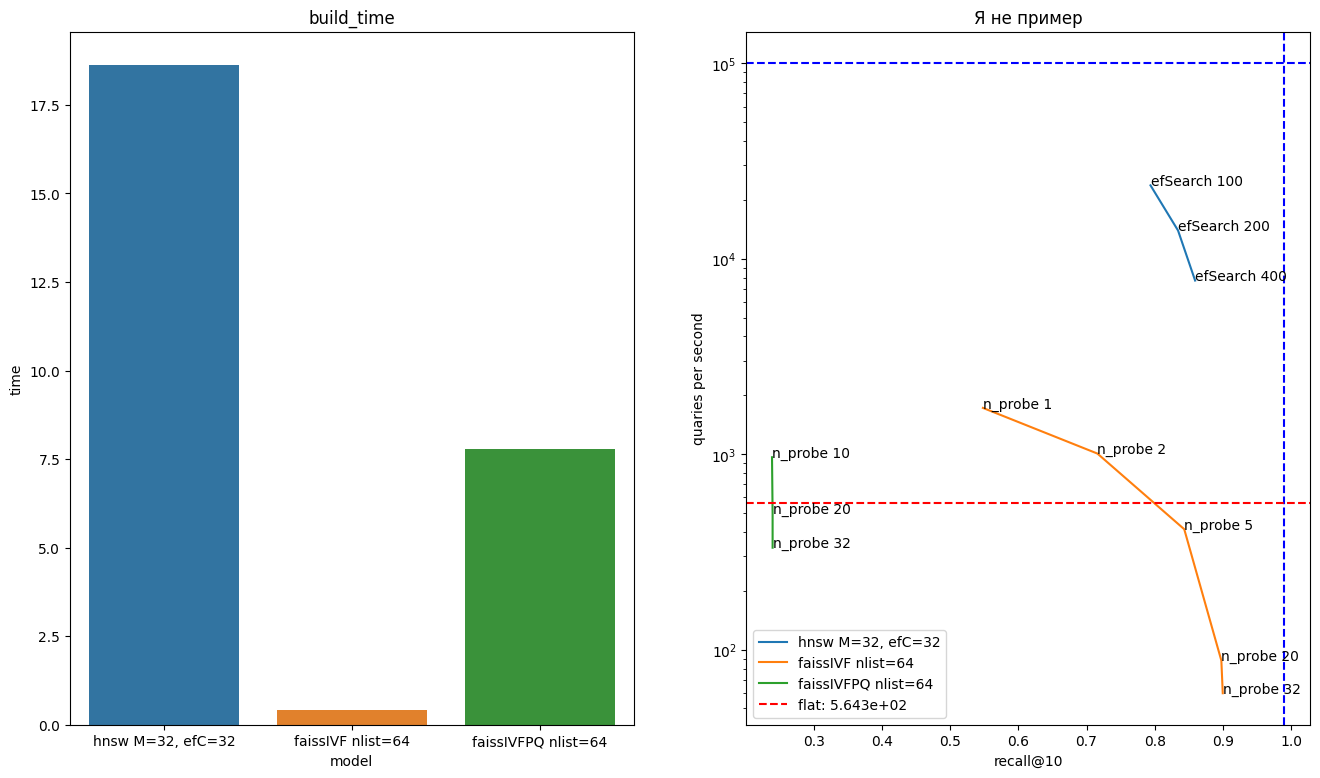

In [30]:
dim = tr_glove.shape[1]
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
    'faissIVFPQ nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'm': 5,
            'nbits': 8,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [10, 20, 32]),
        'search_func': search_faiss
    },
    
}


plot_ann_performance(
    build_data=tr_glove,
    query_data=tst_glove,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

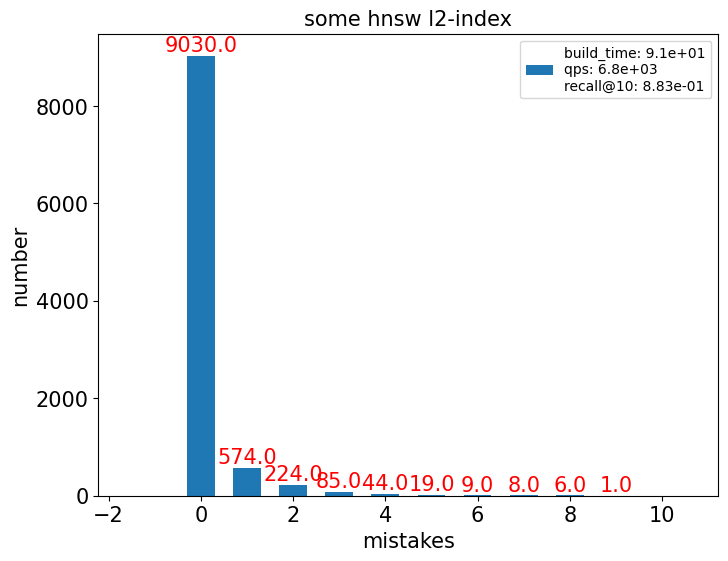

In [4]:
dim = 25
analyze_ann_method(
    build_data=tr_glove,
    query_data=tst_glove,
    build_func=partial(build_hnsw, fixed_params = {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 128}),
    search_func=partial(search_hnsw, efSearch=200),
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    index_name='some hnsw l2-index'
)

Как видно, распределение ошибок показывает, что большего числа ошибок почти не наблюдается, то есть либо 0, либо 1, либо 2 ошибки.

В качестве модели для первого задания возьмем 'hnsw M=64, efC=128, efSearch = 400', так как это наилучшая точность реколла при необходимом времени.

В качестве модели для второго задания возьмем сам флет индекс, так как ни один неточный индекс не дает необходимой точности




IVF строиться очень быстро и дает приемлимую точность, в отоличие от IVFPQ, который работает очень плохо и строиться дольше. HNSW дает очень хорошее время поиска с необходимой точностью, однако базовое время построения очень длинное

## 2.2 NYTimes

Датасет содержит векторы-представления некоторых текстов

In [33]:
tr_ny, tst_ny = get_ann_benchmark_data('nytimes-256-angular')
tr_ny.shape, tst_ny.shape

((290000, 256), (10000, 256))

**Задание:**
Постановка задачи та же, но в этом блоке вам надо ответить только на один вопрос - какую меру близости выбрать: евклидову или косинусную.

Проанализируйте с помощью `plot_ann_performance` и анализа распределения ошибок поведение `faiss.IndexIVFFlat`, `hnswlib.Index` на обеих мерах близости на build-подвыборке в 20k, 50k сэмплов и полной build-выборке.

- [как построить IndexFlat для косинусной меры близости](https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances)

Напишите все свои рассуждения, подкрепляя их графиками, и ответьте на поставленный вопрос.

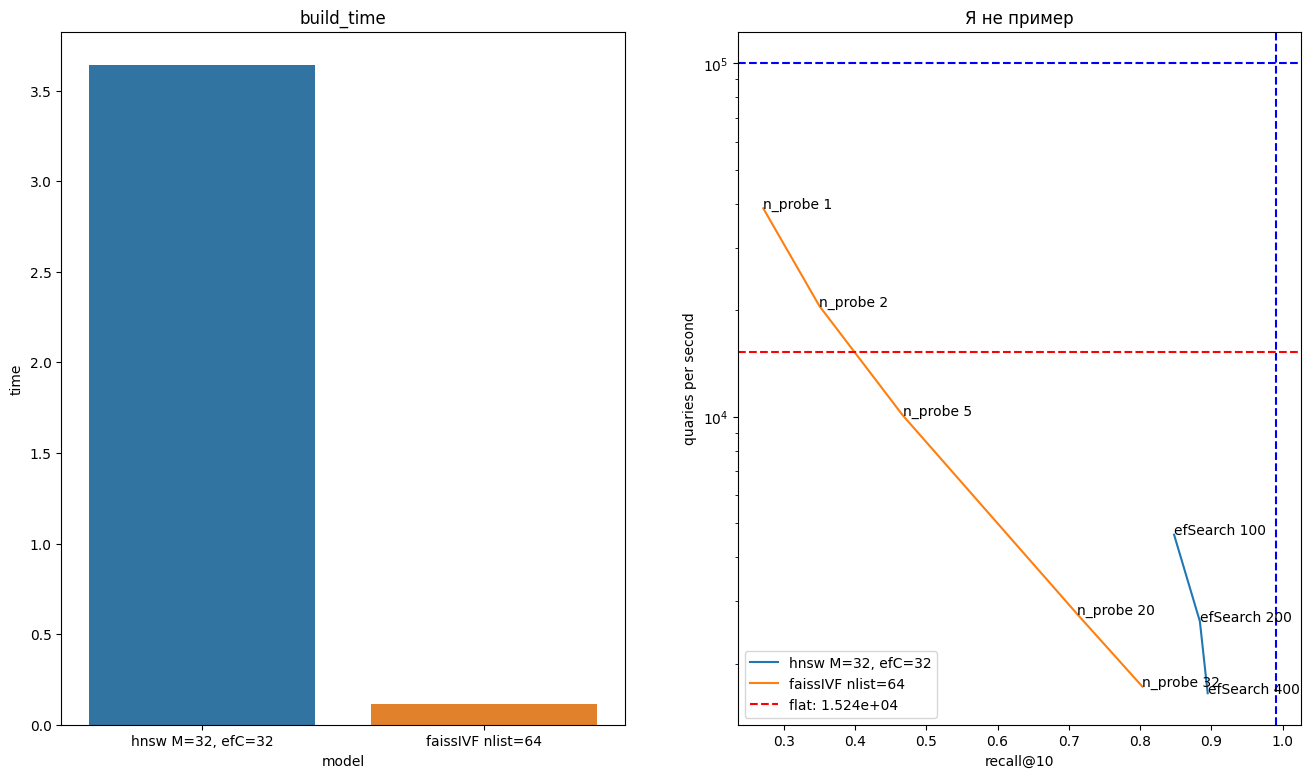

In [38]:
dim = 256
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'ip', 'M': 64, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 64,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_1 = tr_ny[:20000].copy()
test_1 = tst_ny.copy()
faiss.normalize_L2(train_1)
faiss.normalize_L2(test_1)


plot_ann_performance(
    build_data=train_1,
    query_data=test_1,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_ip, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

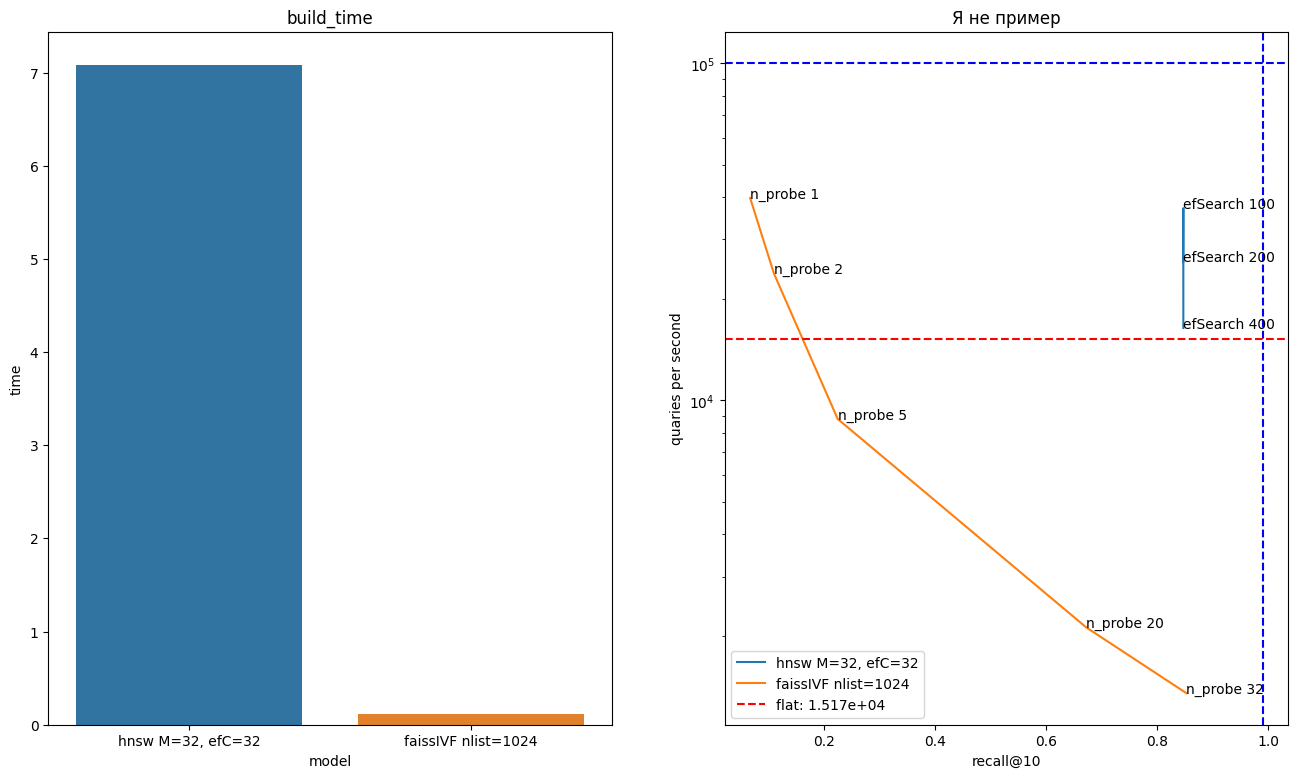

In [44]:
dim = 256
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_2 = tr_ny[:20000].copy()
test_2 = tst_ny.copy()


plot_ann_performance(
    build_data=train_2,
    query_data=test_2,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

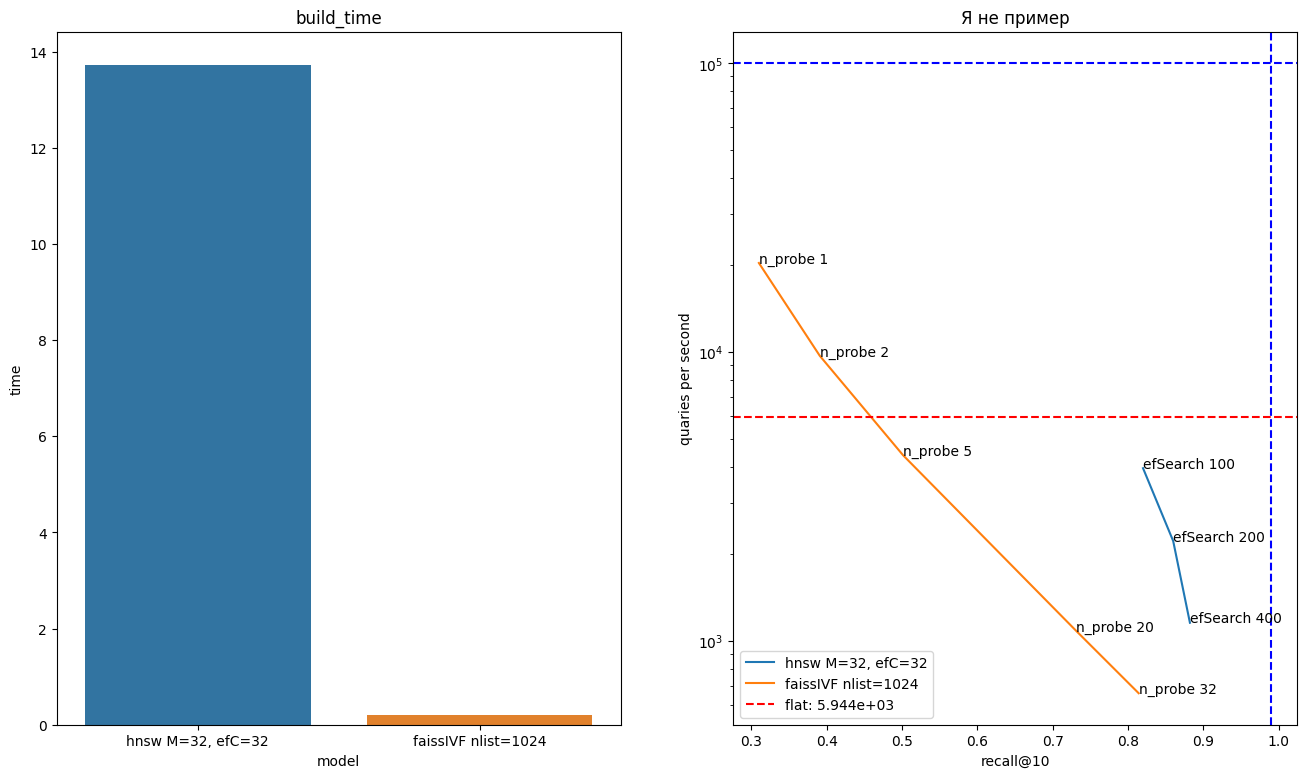

In [40]:
dim = 256
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'ip', 'M': 64, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 64,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_3 = tr_ny[:50000].copy()
test_3 = tst_ny.copy()
faiss.normalize_L2(train_3)
faiss.normalize_L2(test_3)


plot_ann_performance(
    build_data=train_3,
    query_data=test_3,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_ip, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

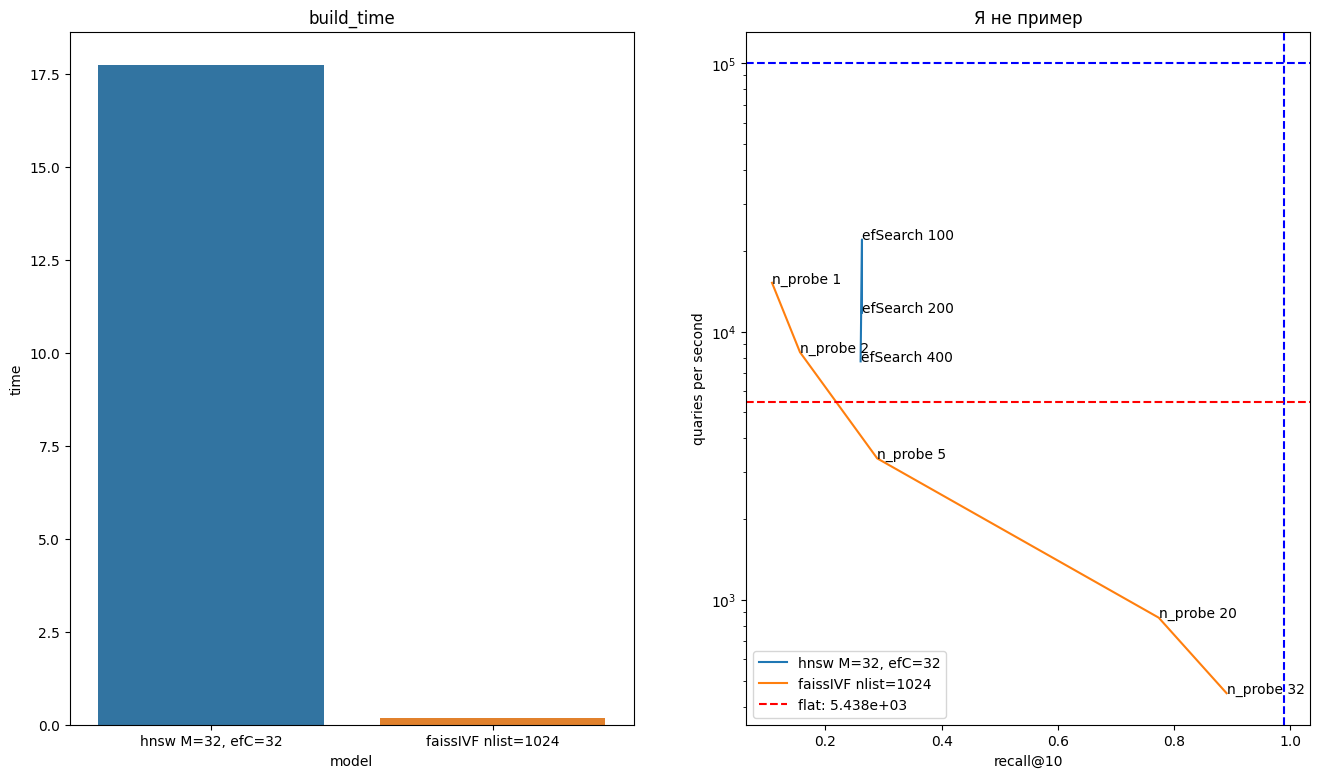

In [46]:
dim = 256
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_4 = tr_ny[:50000].copy()
test_4 = tst_ny.copy()


plot_ann_performance(
    build_data=train_4,
    query_data=test_4,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

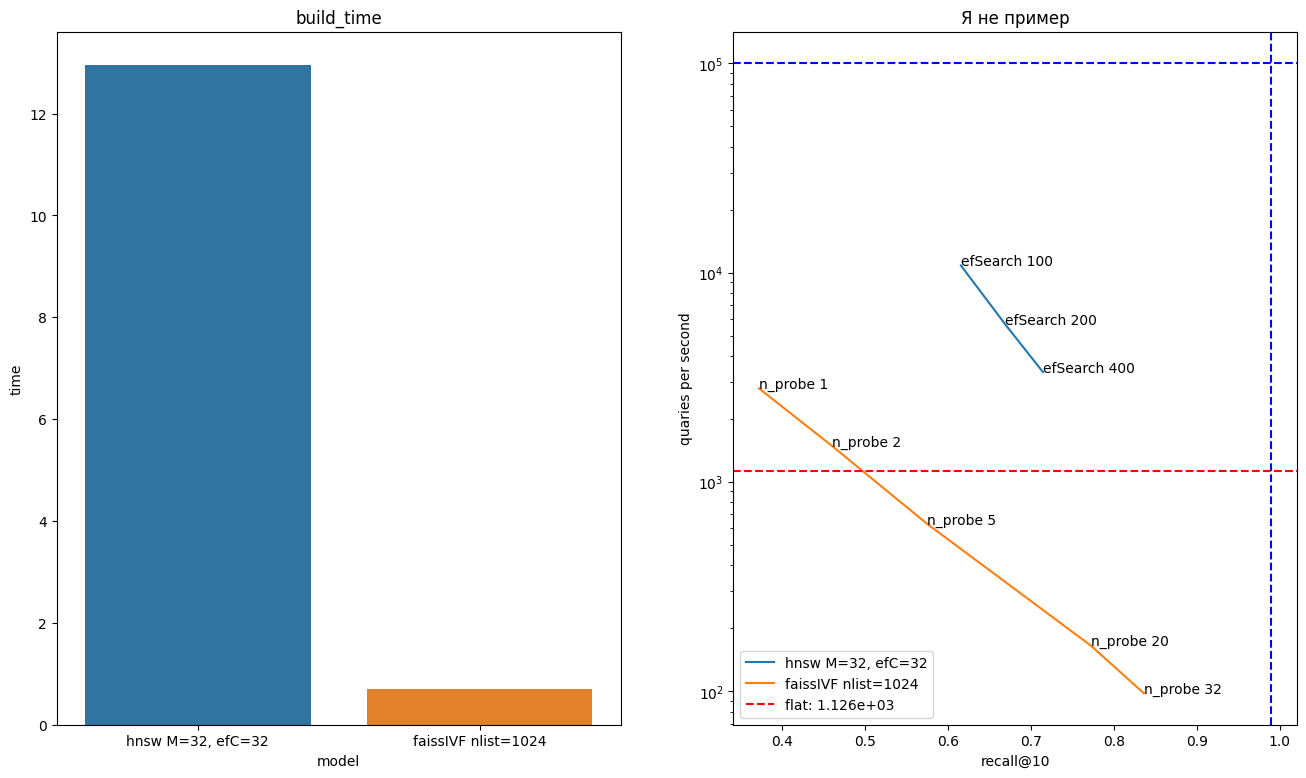

In [41]:
dim = 256
index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'ip', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 64,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_5 = tr_ny.copy()
test_5 = tst_ny.copy()
faiss.normalize_L2(train_5)
faiss.normalize_L2(test_5)


plot_ann_performance(
    build_data=train_5,
    query_data=test_5,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_ip, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

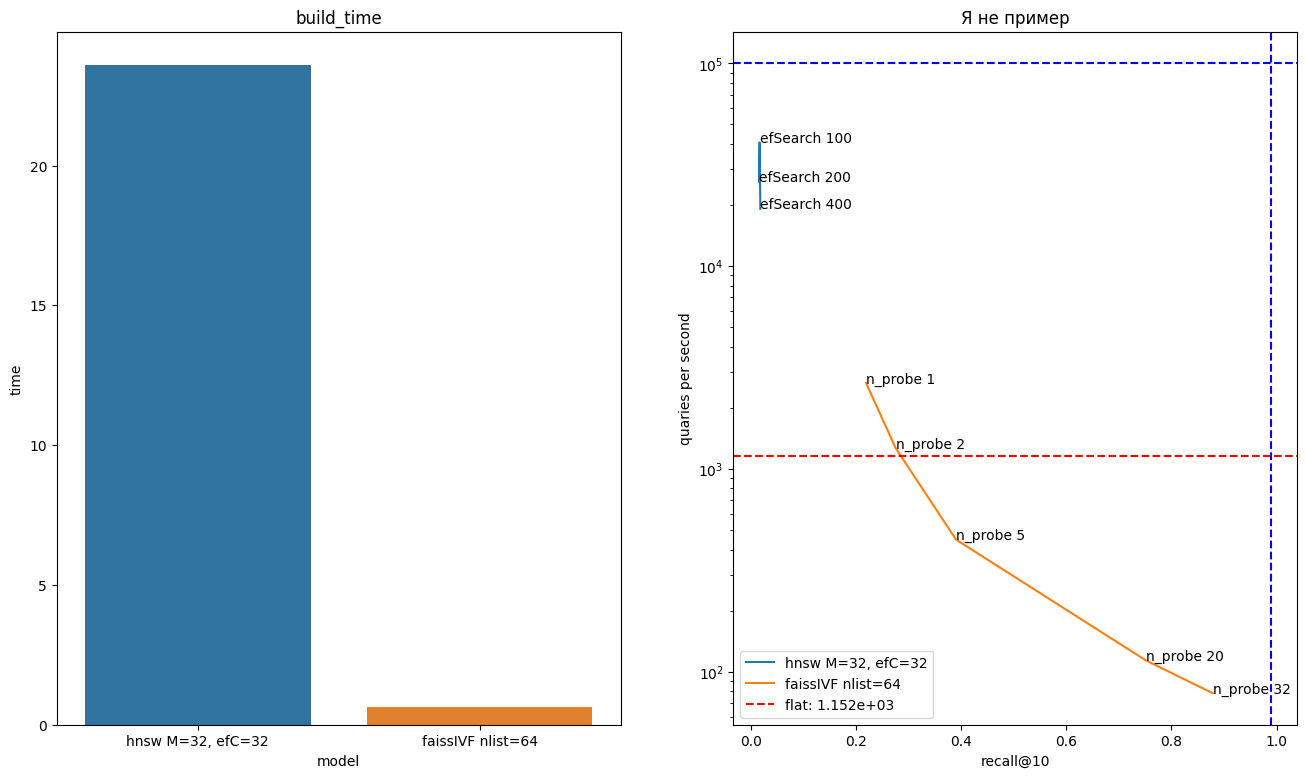

In [42]:
dim = 256
index_dict = { 
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [100, 200, 400]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    
}



train_6 = tr_ny.copy()
test_6 = tst_ny.copy()


plot_ann_performance(
    build_data=train_6,
    query_data=test_6,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

Косинусная метрика дает лучшие показатели, чем l2, особенно для HNSW. Однако время работы у l2 метрики лучше, особенно для HNSW. 

## 2.3 FashionMNIST

Датасет содержит вытянутые в один вектор картинки из датасета [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), с метками

In [3]:
import pandas as pd

tr_df = pd.read_csv('fashion-mnist_train.csv')
tst_df = pd.read_csv('fashion-mnist_test.csv')

tr_mnist = tr_df.iloc[:, 1:].values.astype(np.float32)
tst_mnist = tst_df.iloc[:, 1:].values.astype(np.float32)

tr_labels = tr_df.iloc[:, 0].values
tst_labels = tst_df.iloc[:, 0].values

del tr_df, tst_df

tr_mnist.shape, tst_mnist.shape

((60000, 784), (10000, 784))

**Задание:** выбрать три алгоритма с recall@9 приблизительно 0.6, 0.9, 0.99. Посчитать каждым из этих алгоритмов и алгоритмом точного поиска 9 ближайших по косинусной мере соседей из трейна для всех объектов теста. Предсказать итоговые метки для теста с помощью функции `knn_predict_classification`, померить `sklearn.metrics.balanced_accuracy_score`. Какие выводы можно сделать?

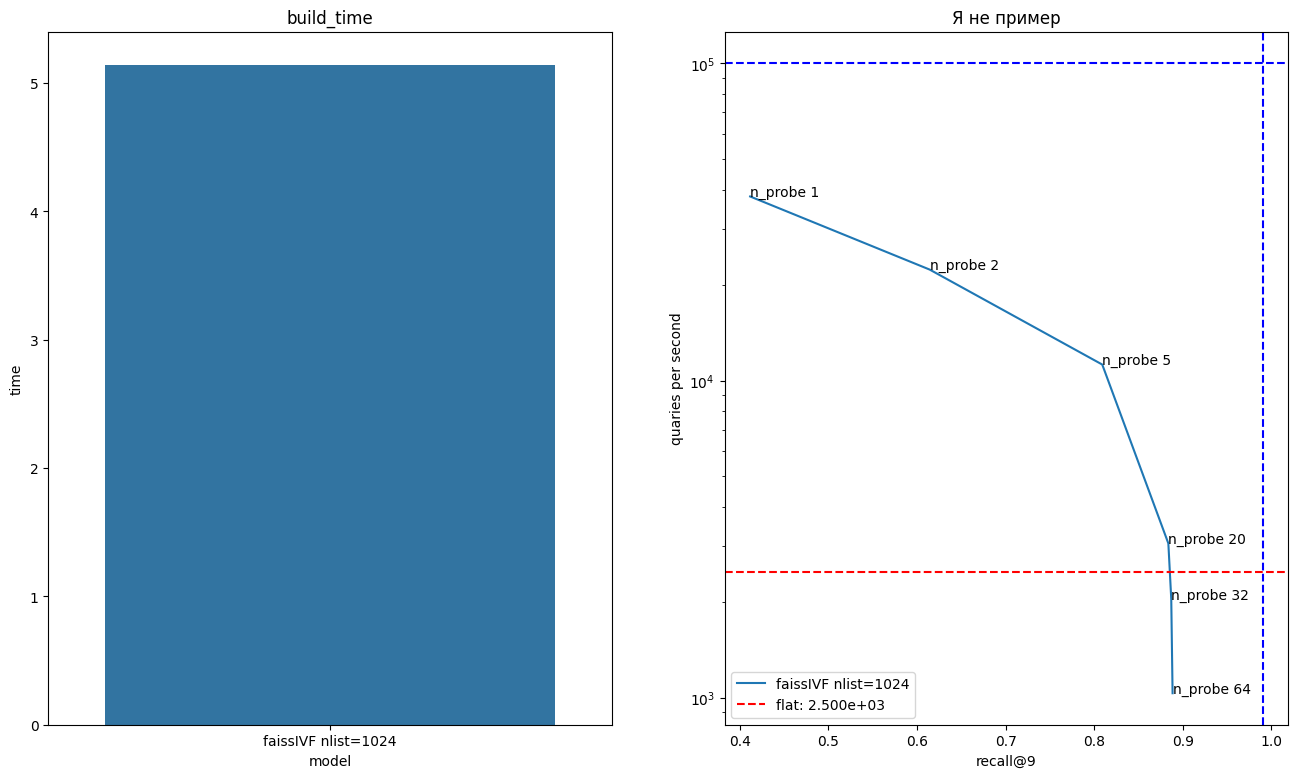

In [6]:
dim = 784
index_dict = { 
    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 1024,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    
}

train = tr_mnist.copy()
test = tst_mnist.copy()
faiss.normalize_L2(train)
faiss.normalize_L2(test)



plot_ann_performance(
    build_data=train,
    query_data=test,
    index_dict=index_dict,
    k=9,
    flat_build_func=partial(build_flat_ip, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я не пример',
    qps_line=1e5,
    recall_line=0.99
)

В качестве алгоритм с реколлом 0.99 разумно взять флет индекс, а качесте алгоритма с приблизительно 60 n_probe = 2, а для реколла 0.9 подойдет n_probe = 20, так как дальнейшее увелечение n_probe не увеличивает реколл, а только уменьшает время.

In [8]:
from utils.utils import *
from sklearn.metrics import balanced_accuracy_score
flat_index, _ = build_flat_ip(train, dim)
true_dist, true_labels, _ = search_flat(flat_index, test, k = 9)



index1, _ = build_IVF(train,
            {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 1024,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        })

dist_1, labels_1, _ = search_faiss(index1, test, 9, 2)


y_pred = knn_predict_classification(distances = dist_1, tr_labels = tr_labels, neighbor_ids = labels_1, 
                           n_classes = np.unique(tr_labels).size)

print(balanced_accuracy_score(tst_labels, y_pred), " скор для nprobe = 2")

0.8549000000000001  скор для nprobe = 2


In [11]:
index2, _ = build_IVF(train,
            {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 1024,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 1
        })

dist_2, labels_2, _ = search_faiss(index2, test, 9, 20)


y_pred2 = knn_predict_classification(distances = dist_2, tr_labels = tr_labels, neighbor_ids = labels_2, 
                           n_classes = np.unique(tr_labels).size)

print(balanced_accuracy_score(tst_labels, y_pred2), " скор для nprobe = 20")

0.8551  скор для nprobe = 20


In [12]:
y_pred3 = knn_predict_classification(distances = true_dist, tr_labels = tr_labels, neighbor_ids = true_labels, 
                           n_classes = np.unique(tr_labels).size)

print(balanced_accuracy_score(tst_labels, y_pred3), " скор для точного KNN")

0.8562000000000001  скор для точного KNN


Можно заметить, что скор особо не меняется, хотя и реколл отключается очень сильно. Однако, он все равно растет в пределах 0.001.

# 3. Крабы (6 баллов)

[описание данных](https://www.kaggle.com/datasets/sidhus/crab-age-prediction) <br>
[послать ответ](https://www.kaggle.com/competitions/aim-2023-crabs/leaderboard)

В этом блоке вам предстоит полноценно решить задачу предсказания возраста крабов с помощью ближайших соседей. Данные и информацию о них можно найти по ссылкам выше. Вам нужно скачать данные, предсказать возраст наилучшим способом и отправить в kaggle. **За задание можно получить баллы только в случае побития бейслайна на паблик лидерборде.**

Задание с хорошей вероятностью включает в себя:
- анализ распределений признаков и их физического смысла
- предобработка и трансформация данных
- придумывание и воплощение в жизнь своего видения близости между крабами!
- выбор валидации и тюнинг гиперпараметров
- получение ближайших соседей для теста
- получение предсказаний для теста (проще написать свою функцию, чем разобраться в том, как это сделать через sklearn)

Важно:
- можно использовать любые индексы / методы поиска соседей (но задача спокойно решается полным перебором, так что можно не мудрить)
- можно конструировать дополнительные признаки из имеющихся данных
- нельзя пользоваться никакими другими методами машинного обучения для решения этой задачи (в т.ч. и для генерации признаков)
- нельзя использовать дополнительные данные
- в данном блоке должен быть приведен чистый (без ненужного кода / ячеек) пайплайн работы с данными, который приводит вас от 
    этапа загрузки данных к  получению предсказаний.
    Исследовательская работа, подбор гиперпараметров и прочие вещи выполняйте в другом ноутбуке, который тоже нужно будет 
    прикрепить в классрум
    
Для начала можно попробовать такой пайплайн:
- `scipy.spatial.distance.cdist` на всех числовых фичах по евклидовой метрике
- `get_k_neighbors` для взятого из головы k
- напишите `knn_predict_regression` по аналогии с классификацией и предскажите тест
- сдайте :)

In [4]:
import pandas as pd
import numpy as np
from utils.utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist


tr = pd.read_csv("crabs_train.csv")
tst = pd.read_csv("crabs_test.csv")
for df in [tr, tst]:
    df.colums = df.columns.str.lower()
    df.rename(columns = 
              {
                  'shucked weight': 'shucked_weight',
                  'viscera weight': 'viscera_weight',
                  'shell weight': 'shell_weight'
              }, inplace = True)
    df['height'] = np.where(df['height']==0, 0.025,df['height'])
    df["volume"] = df["length"] * df["diameter"] * df['height']
    df['approx_density'] = df['weight'] / df['volume']
    scaler = MinMaxScaler()
    df['approx_density'] = scaler.fit_transform(df['approx_density'].to_numpy().reshape(-1, 1))
    df['bmi']= df['weight'] / (df['height'] ** 2)
    df['bmi'] = scaler.fit_transform(df['bmi'].to_numpy().reshape(-1, 1))
    df['volume'] = scaler.fit_transform(df['volume'].to_numpy().reshape(-1, 1))
    df["water_loss"]=df["weight"] - df["shucked_weight"] - df['viscera_weight'] - df['shell_weight']
    df["water_loss"] = scaler.fit_transform(df['water_loss'].to_numpy().reshape(-1, 1))

tr.drop_duplicates(subset=['length', 'diameter', 'height', 'weight'], keep='first', inplace = True)
y_tr = tr["age"].values
#y_val = val.age.values
#val = val.drop(columns = ["age"])
tr = tr.drop(columns = ["age"])
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60330 entries, 0 to 65999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             60330 non-null  object 
 1   length          60330 non-null  float64
 2   diameter        60330 non-null  float64
 3   height          60330 non-null  float64
 4   weight          60330 non-null  float64
 5   shucked_weight  60330 non-null  float64
 6   viscera_weight  60330 non-null  float64
 7   shell_weight    60330 non-null  float64
 8   volume          60330 non-null  float64
 9   approx_density  60330 non-null  float64
 10  bmi             60330 non-null  float64
 11  water_loss      60330 non-null  float64
dtypes: float64(11), object(1)
memory usage: 6.0+ MB


/var/folders/x6/b_ylqyd127s0ckfw_r19b2880000gn/T/ipykernel_35031/4252029985.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.colums = df.columns.str.lower()
/var/folders/x6/b_ylqyd127s0ckfw_r19b2880000gn/T/ipykernel_35031/4252029985.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.colums = df.columns.str.lower()


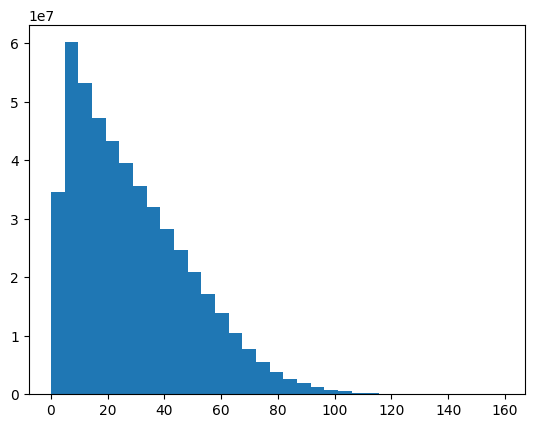

In [5]:
numeric_features = tr.select_dtypes(np.number).columns
euc_distances = cdist(
    tst[numeric_features].values,
    tr[numeric_features].values,
    metric = 'cityblock'
)

plt.hist(euc_distances.ravel(), bins = 33)
plt.show()

(2550, 18965)

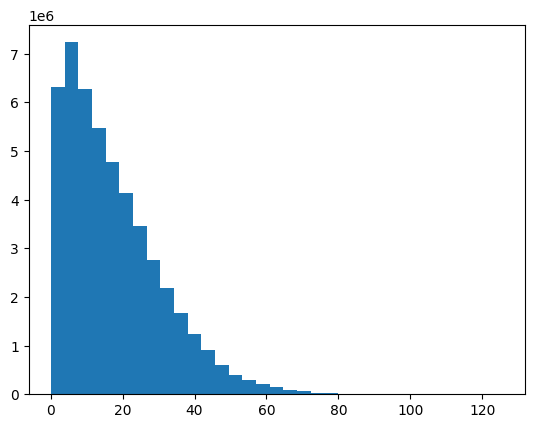

In [6]:
numeric_features = tr.select_dtypes(np.number).columns
indeces_I = (tr['sex'] == 'I').to_numpy()
indeces_not_I = (tr['sex'] != 'I').to_numpy()
tr_I = tr[tr['sex'] == 'I']
tst_I = tst[tst['sex'] == 'I']
y_I = y_tr[indeces_I]
euc_distances_I = cdist(
        tst_I[numeric_features].values,
        tr_I[numeric_features].values,
        metric = 'cityblock'
    )
plt.hist(euc_distances_I.ravel(), bins = 33)
euc_distances_I.shape

In [7]:
sorted_distances_I, indices_I = get_k_neighbors(euc_distances_I, k = 145)

In [8]:
sorted_distances_scaled_I = 1 / (sorted_distances_I + 1e-10)

In [9]:
y_pred_I = knn_predict_regression(indices_I, y_I, distances = sorted_distances_scaled_I).round()

In [10]:
indeces_not_I_ans = (tst['sex'] != 'I').to_numpy()
indeces_I_ans = (tst['sex'] == 'I').to_numpy()

(5501, 41365)

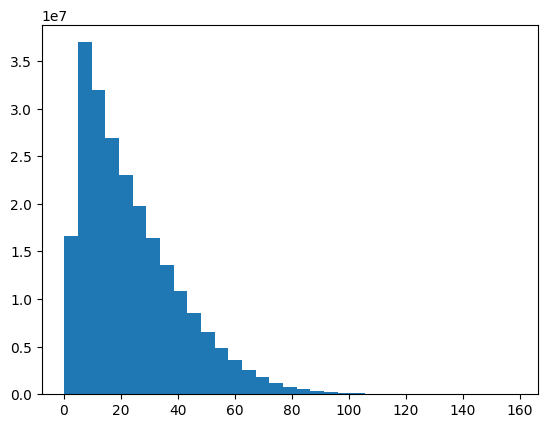

In [11]:
indeces_not_I = (tr['sex'] != 'I').to_numpy()
tr_not_I = tr[tr['sex'] != 'I']
tst_not_I = tst[tst['sex'] != 'I']
y_not_I = y_tr[indeces_not_I]
euc_distances_not_I = cdist(
        tst_not_I[numeric_features].values,
        tr_not_I[numeric_features].values,
        metric = 'cityblock'
    )
plt.hist(euc_distances_not_I.ravel(), bins = 33)
euc_distances_not_I.shape

In [12]:
sorted_distances_not_I, indices_not_I = get_k_neighbors(euc_distances_not_I, k = 75)

In [13]:
sorted_distances_scaled_not_I = 1 / (sorted_distances_not_I + 1e-10)

In [14]:
y_pred_not_I = knn_predict_regression(indices_not_I, y_not_I, distances = sorted_distances_scaled_not_I).round()

In [15]:
y_pred = np.zeros(y_pred_not_I.size + y_pred_I.size)
y_pred[indeces_not_I_ans] = y_pred_not_I
y_pred[indeces_I_ans] = y_pred_I
y_pred.shape

(8051,)

In [16]:
res = pd.DataFrame({'id': np.arange(y_pred.shape[0]), 'age': y_pred})
res

,id,age
0,0,11.0
1,1,11.0
2,2,7.0
3,3,8.0
4,4,10.0
...,...,...
8046,8046,12.0
8047,8047,12.0
8048,8048,9.0
8049,8049,9.0


In [17]:
res.to_csv("my_submission.csv", index = False)